In [1]:

from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
!pip install evaluate
import evaluate
from sklearn.model_selection import train_test_split



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [2]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

In [3]:
model_small= 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_small)
model = T5ForConditionalGeneration.from_pretrained(model_small)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [4]:
!pip install datasets

In [5]:
#I am importing BioASQ dataset to fine-tune the t5 model on question answering task
from datasets import load_dataset
dataset = load_dataset("kroshan/BioASQ")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
answers = []
contexts = []

for text in dataset["train"]["text"]:
    answer, context = text.split("<answer>")[1].split("<context>")
    answers.append(answer.strip())
    contexts.append(context.strip())

dataset["train"] = dataset["train"].add_column("answer", answers)
dataset["train"] = dataset["train"].add_column("context", contexts)

In [7]:
import pandas as pd

In [8]:
data = pd.DataFrame(dataset["train"])
data = data.drop(columns=["text"])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266 entries, 0 to 3265
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  3266 non-null   object
 1   answer    3266 non-null   object
 2   context   3266 non-null   object
dtypes: object(3)
memory usage: 76.7+ KB


In [10]:
data

,question,answer,context
0,What is the inheritance pattern of Li–Fraumeni...,autosomal dominant,Balanced t(11;15)(q23;q15) in a TP53+/+ breast...
1,What is the inheritance pattern of Li–Fraumeni...,autosomal dominant,Genetic modeling of Li-Fraumeni syndrome in ze...
2,Which type of lung cancer is afatinib used for?,EGFR-mutant NSCLC,Clinical perspective of afatinib in non-small ...
3,Which hormone abnormalities are characteristic...,thyroid,"DOCA sensitive pendrin expression in kidney, h..."
4,Which hormone abnormalities are characteristic...,thyroid,Clinical and molecular characteristics of Pend...
...,...,...,...
3261,Which is the receptor for substrates of Chaper...,lamp2a,Regulation of lamp2a levels in the lysosomal m...
3262,Which is the receptor for substrates of Chaper...,Lamp2a,Unique properties of lamp2a compared to other ...
3263,Which is the receptor for substrates of Chaper...,lamp2a,Unique properties of lamp2a compared to other ...
3264,Which is the receptor for substrates of Chaper...,LAMP2A,Dietary lipids and aging compromise chaperone-...


In [11]:
from torch.utils.data import Dataset, DataLoader, RandomSampler


In [12]:
import torch

def tokenize_data(data, tokenizer):
    tokenized_data = []
    for ind in range(len(data)):
        question = data["question"][ind]
        context = data["context"][ind]
        answer = data['answer'][ind]

        questionTk = tokenizer(question, context, max_length=256, padding="max_length",
                                       truncation=True, pad_to_max_length=True, add_special_tokens=True)
        answerTk = tokenizer(answer, max_length=32, padding="max_length",
                                     truncation=True, pad_to_max_length=True, add_special_tokens=True)

        lb = torch.tensor(answerTk["input_ids"], dtype=torch.long)
        lb[lb == 0] = -100

        tokenized_data.append({
            "input_ids": torch.tensor(questionTk["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(questionTk["attention_mask"], dtype=torch.long),
            "labels": lb,
            "decoder_attention_mask": torch.tensor(answerTk["attention_mask"], dtype=torch.long)
        })

    return tokenized_data


In [13]:
trainData, testData = train_test_split(data, test_size=0.2, random_state=42)

train_rand_sampler = RandomSampler(trainData.index)
test_rand_sampler = RandomSampler(testData.index)

tokenized_data = tokenize_data(data, tokenizer)

train_loader_output = DataLoader(tokenized_data, batch_size=4, sampler=train_rand_sampler)
test_loader_output = DataLoader(tokenized_data, batch_size=4, sampler=test_rand_sampler)

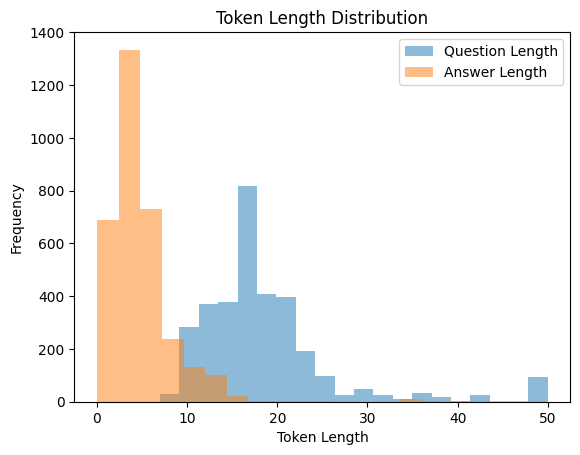

Special Tokens: {'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36

In [14]:
import matplotlib.pyplot as plt

question_lengths = [len(tokenizer.tokenize(question)) for question in data["question"]]
answer_lengths = [len(tokenizer.tokenize(answer)) for answer in data["answer"]]

plt.hist(question_lengths, bins=20, alpha=0.5, label='Question Length')
plt.hist(answer_lengths, bins=20, alpha=0.5, label='Answer Length')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

special_tokens = tokenizer.special_tokens_map_extended
print("Special Tokens:", special_tokens)

max_question_length = max(question_lengths)
max_answer_length = max(answer_lengths)
print("Max Question Length:", max_question_length)
print("Max Answer Length:", max_answer_length)

overlap_count = 0
for ind in range(len(data)):
    question_tokens = set(tokenizer.tokenize(data["question"][ind]))
    answer_tokens = set(tokenizer.tokenize(data['answer'][ind]))
    overlap_count += len(question_tokens.intersection(answer_tokens))

print("Token Overlaps Count:", overlap_count)


In [15]:
from tqdm import tqdm
from torch.optim import Adam

In [16]:
import torch.optim as optim

epochs = 3
optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_batch_count = 0

    for batch in tqdm(train_loader_output, desc="train batches"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        decoder_attention_mask = batch["decoder_attention_mask"]

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        optimizer.zero_grad()
        outputs.loss.backward()
        optimizer.step()

    model.eval()
    for batch in tqdm(test_loader_output, desc="val batches"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        decoder_attention_mask = batch["decoder_attention_mask"]

        outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask
                        )

        optimizer.zero_grad()
        outputs.loss.backward()
        optimizer.step()



val batches: 100%|██████████| 164/164 [08:49<00:00,  3.23s/it]


In [17]:
def predict_answer_score(context, question, ref_answer=None):
    inputs = tokenizer(question, context, max_length=256, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)

    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

    predicted_answer = tokenizer.decode(outputs.flatten(), skip_special_tokens=True)

    if ref_answer:
        bleu = evaluate.load("google_bleu")
        score = bleu.compute(predictions=[predicted_answer], references=[ref_answer])

        return {
            "reference": ref_answer,
            "prediction": predicted_answer,
            "bleu score": score
        }
    else:
        return predicted_answer


In [18]:
import numpy as np

In [24]:
bleu_scores = []
i=0
data_1000 = data.head(1000)
for start_row in range(0, len(data_1000)):
    row = data_1000.iloc[start_row]

    context = row["context"]
    question = row["question"]
    answer = row["answer"]
    score = predict_answer_score(context, question, answer)

    bleu_scores.append(score["bleu score"]['google_bleu'])
    if i<70 and i>20:
      print(score)
    i+=1



{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'Thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 0.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'bleu score': {'google_bleu': 1.0}}
{'reference': 'thyroid', 'prediction': 'thyroid', 'ble

In [25]:
average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU Score : {average_bleu_score}")

Average BLEU Score : 0.7322454292256393


In [26]:
context = data.iloc[21]["context"]
question = data.iloc[21]["question"]
answer = data.iloc[21]["answer"]

predict_answer_score(context, question, answer)

{'reference': 'thyroid',
 'prediction': 'thyroid',
 'bleu score': {'google_bleu': 1.0}}

In [29]:
context = data.iloc[120]["context"]
question = data.iloc[120]["question"]
answer = data.iloc[120]["answer"]

predict_answer_score(context, question, answer)

{'reference': 'Calsequestrin',
 'prediction': 'Calsequestrin',
 'bleu score': {'google_bleu': 1.0}}

In [30]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
model.push_to_hub("starman76/t5_500")
tokenizer.push_to_hub("starman76/t5_500")

README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/starman76/t5_500/commit/c570e53f0a5c1aa76939c97005a112ca4c7d4e9b', commit_message='Upload tokenizer', commit_description='', oid='c570e53f0a5c1aa76939c97005a112ca4c7d4e9b', pr_url=None, pr_revision=None, pr_num=None)

In [35]:
data.iloc[1111]['context']

'The Recognition of Stroke in the Emergency Room (ROSIER) scale: development and validation of a stroke recognition instrument. BACKGROUND: In patients with acute stroke, rapid intervention is crucial to maximise early treatment benefits. Stroke patients commonly have their first contact with medical staff in the emergency room (ER). We designed and validated a stroke recognition tool-the Recognition of Stroke in the Emergency Room (ROSIER) scale-for use by ER physicians. METHODS: We prospectively collected data for 1 year (development phase) on the clinical characteristics of patients with suspected acute stroke who were admitted to hospital from the ER. We used logistic regression analysis and clinical reasoning to develop a stroke recognition instrument for application in this setting. Patients with suspected transient ischaemic attack (TIA) with no symptoms or signs when assessed in the ER were excluded from the analysis. The instrument was assessed using the baseline 1-year datase

In [36]:
data.iloc[1111]['question']

'ROSIER scale is used for which disorder?'

In [37]:
data.iloc[1111]['answer']

'stroke'